In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

# 1. Load Data
#### torchvision, torch.utils.data packages 이용
#### classify bees and ants->small subset of imagenet
#### pretrained model과 같은 normalization을 적용해야 함에 유의 (이후에 model training, evaluation method도 확인)

In [2]:
data_transforms={
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir='./hymenoptera_data'
image_datasets={x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
               for x in ['train', 'val']}
dataloaders={x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
            for x in ['train', 'val']}
dataset_sizes={x: len(image_datasets[x]) for x in ['train', 'val']}
class_names=image_datasets['train'].classes

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# 2. Visualize a few images
#### visualize a few training images to understand data augmentations

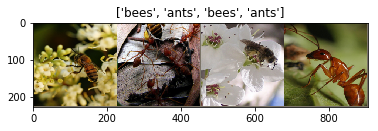

In [3]:
def imshow(inp, title=None):
    inp=inp.numpy().transpose((1, 2, 0))
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    inp=std*inp+mean
    inp=np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes=next(iter(dataloaders['train']))

# Make a grid from batch
out=torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 3. Training the model
#### scheduling the learning rate, saving the best model

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since=time.time()
    
    best_model_wts=copy.deepcopy(model.state_dict())  # save best model
    best_acc=0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase=='train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode
                
            running_loss=0.0
            running_corrects=0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs=inputs.to(device)
                labels=labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs=model(inputs)
                    _, preds=torch.max(outputs, 1)
                    loss=criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+=torch.sum(preds == labels.data)
                
            epoch_loss=running_loss/dataset_sizes[phase]
            epoch_acc=running_corrects.double()/dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the new best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc=epoch_acc
                best_model_wts=copy.deepcopy(model.state_dict())
                
                
        print()
        
    time_elapsed=time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed%60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
            

# 4. Visualizing model predictions
#### Generic function to display predictions for a few images

In [5]:
def visualize_model(model, num_images=6):
    was_training=model.training
    model.eval()
    images_so_far=0
    fig=plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs=inputs.to(device)
            labels=labels.to(device)
            
            outputs=model(inputs)
            _, preds=torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far+=1
                ax=plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
            

# 5. Finetuning the convnet
#### Load a pretrained model and reset final fully connected layer

In [6]:
model_ft=models.resnet18(pretrained=True)  # load pretrained model
num_ftrs=model_ft.fc.in_features  # input size of fully connected layer of the pretrained model
model_ft.fc=nn.Linear(num_ftrs, 2)  #  reset final fully connected layer: input size same, 2 output classes

model_ft=model_ft.to(device)

criterion=nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft=optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay Learning Rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler=lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 6. Train and evaluate

In [7]:
model_ft=train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.5308 Acc: 0.7336
val Loss: 0.2138 Acc: 0.9150

Epoch 1/4
----------
train Loss: 0.4214 Acc: 0.8197
val Loss: 0.1980 Acc: 0.9281

Epoch 2/4
----------
train Loss: 0.5886 Acc: 0.7746
val Loss: 0.5697 Acc: 0.8431

Epoch 3/4
----------
train Loss: 0.4931 Acc: 0.7664
val Loss: 0.3704 Acc: 0.8627

Epoch 4/4
----------
train Loss: 0.4625 Acc: 0.8115
val Loss: 0.3965 Acc: 0.8562

Training complete in 41m 57s
Best val Acc: 0.928105


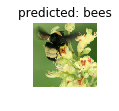

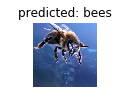

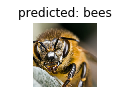

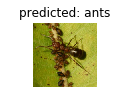

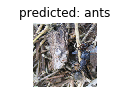

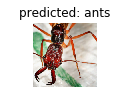

In [8]:
visualize_model(model_ft)

# 7. ConvNet as fixed feature extractor
#### Need to freeze all the network except the final layer
#### Set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()

In [9]:
model_conv=torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad=False
    
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs=model_conv.fc.in_features
model_conv.fc=nn.Linear(num_ftrs, 2)

model_conv=model_conv.to(device)

criterion=nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv=optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler=lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# 8. Train and evaluate

In [10]:
model_conv=train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.6023 Acc: 0.7049
val Loss: 0.4136 Acc: 0.7843

Epoch 1/4
----------
train Loss: 0.4498 Acc: 0.7664
val Loss: 0.2075 Acc: 0.9477

Epoch 2/4
----------
train Loss: 0.4502 Acc: 0.7992
val Loss: 0.1950 Acc: 0.9477

Epoch 3/4
----------
train Loss: 0.3985 Acc: 0.8361
val Loss: 0.2452 Acc: 0.8954

Epoch 4/4
----------
train Loss: 0.4352 Acc: 0.8033
val Loss: 0.3056 Acc: 0.9216

Training complete in 22m 53s
Best val Acc: 0.947712


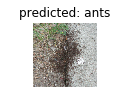

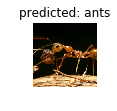

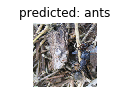

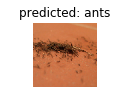

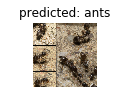

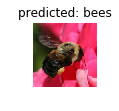

In [11]:
visualize_model(model_conv)

plt.ioff()
plt.show()

# 9. Compare with model from scratch

In [12]:
model_sc=models.resnet18(pretrained=False)
num_ftrs=model_sc.fc.in_features  
model_sc.fc=nn.Linear(num_ftrs, 2)

model_sc=model_sc.to(device)

criterion=nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_sc=optim.SGD(model_sc.parameters(), lr=0.001, momentum=0.9)

# Decay Learning Rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler=lr_scheduler.StepLR(optimizer_sc, step_size=7, gamma=0.1)

In [13]:
model_sc=train_model(model_sc, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.7361 Acc: 0.4467
val Loss: 0.8091 Acc: 0.3856

Epoch 1/4
----------
train Loss: 0.7356 Acc: 0.4467
val Loss: 0.8033 Acc: 0.4052

Epoch 2/4
----------
train Loss: 0.7330 Acc: 0.4836
val Loss: 0.8024 Acc: 0.3922

Epoch 3/4
----------
train Loss: 0.7310 Acc: 0.4836
val Loss: 0.8029 Acc: 0.3856

Epoch 4/4
----------
train Loss: 0.7409 Acc: 0.4672
val Loss: 0.8251 Acc: 0.3987

Training complete in 39m 9s
Best val Acc: 0.405229


# Conclusion
#### ConvNet finetuning: Training complete in 41m 57s, Best val Acc: 0.928105
#### ConvNet as feature extractor: Training complete in 22m 53s, Best val Acc: 0.947712
#### Scratch: Training complete in 39m 9s, Best val Acc: 0.405229
#### When we have little training data, using pretrained models as feature extracor is a good choice for performance. Also, it takes little time.